In [52]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from PIL import Image
import albumentations as A
from tqdm import tqdm_notebook
import typing as tp

import pandas as pd
import numpy as np
import os
import gc

In [105]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(4608, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )


    def forward(self, x):
        return self.net(x)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output


def plot_loss(values):
    clear_output()
    with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
        train_loss = values["train_loss"]
        # accuracy = values["accuracy"]
        n = len(train_loss)

        plt.figure(figsize=(10, 5))
        
        # plt.subplot(1, 2, 1)
        plt.plot(range(1, n + 1), train_loss)
        plt.title('Train loss')

        # plt.subplot(1, 2, 2)
        # plt.plot(range(1, len(accuracy) + 1), accuracy)
        # plt.title('Accuracy Val')

        plt.show()

In [98]:
def get_list_grad_params(net: nn.Module) -> tp.List[torch.Tensor]:
    return [param.grad.detach().cpu() for param in net.parameters()]

def calc_grad_info(net: nn.Module, info: tp.List[torch.Tensor]):
    new_grads = get_list_grad_params(net)
    if not info:
        return new_grads
    return [new_grad + cur_grad for new_grad, cur_grad in zip(new_grads, info)]

def get_dif(grad_info_1: tp.List[torch.Tensor], grad_info_2: tp.List[torch.Tensor]) -> tp.List[torch.Tensor]:
    return [grad_1 - grad_2 for grad_1, grad_2 in zip(grad_info_1, grad_info_2)]

def mult_grad(info: tp.List[torch.Tensor], mult: float):
    return [grad * mult for grad in info] 

def get_grad_norm(grads: tp.List[torch.Tensor]):
    return np.sqrt(sum(grad.norm().item() ** 2 for grad in grads))

def get_cosinus_grad(grad_info_1: tp.List[torch.Tensor], grad_info_2: tp.List[torch.Tensor]) -> tp.List[torch.Tensor]:
    sc = sum([(grad_1 * grad_2).sum() for grad_1, grad_2 in zip(grad_info_1, grad_info_2)]).item()
    return sc / get_grad_norm(grad_info_1) / get_grad_norm(grad_info_2)



In [100]:
def train_cycle(
    model,
    optim,
    criterion,
    epochs,
    device,
    dataloader,
    mult: float,
    verbose=True,
    bound_batches = None,
    step: int = 1
):
    grad_history = []
    history = {}
    history["train_loss"] = []
    history["accuracy"] = []

    for _ in range(epochs):
        model.train()
        
        full_grad = []
        cur_grad = []
        for x, y in tqdm_notebook(dataloader):
            optim.zero_grad()
            x = x.to(device)
            logits = model(x)
            y_ = y.to(device)
            loss_batch = criterion(logits, y_)
            loss_batch.backward()
            full_grad = calc_grad_info(model, full_grad)
            cur_grad = mult_grad(get_list_grad_params(model), mult=mult)
            del x
            del y
            if 'cuda' in device:
                torch.cuda.synchronize()
                torch.cuda.empty_cache()
                gc.collect()

        grad_history.append((get_grad_norm(cur_grad),
                             get_grad_norm(full_grad),
                             get_grad_norm(get_dif(full_grad, cur_grad))))
        optim.step()
        loss_ = loss_batch.detach().item()
        history["train_loss"].append(loss_)

        if verbose:
            plot_loss(history)

    return model, history, grad_history

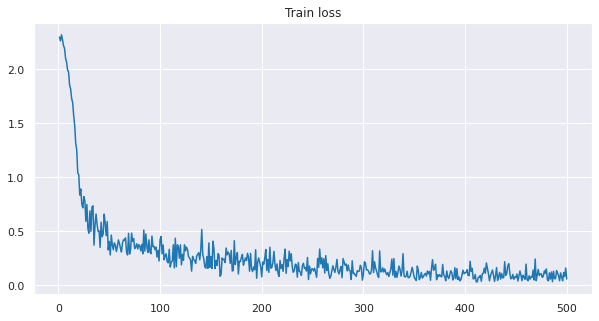

In [107]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = Net().to(device)

dataset_train = datasets.MNIST('../datasets/mnist',
                               train=True,
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

batch_size: int = 256
workers: int = 6

dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               num_workers=workers,
                                               batch_size=batch_size,
                                               sampler=torch.utils.data.RandomSampler(dataset_train))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
verbose = True

epochs = 500

model, history, grad_history = train_cycle(model,
                                           optimizer,
                                           criterion,
                                           epochs,
                                           device,
                                           dataloader_train,
                                           mult=len(dataset_train) / batch_size)

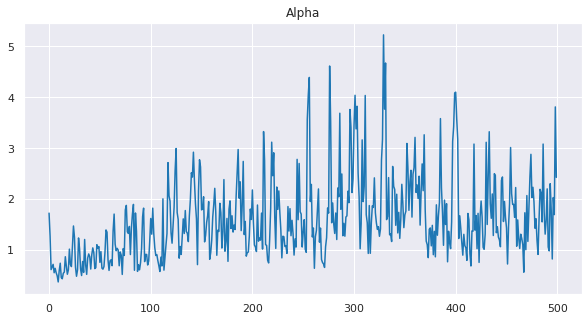

In [148]:
with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 5))

    error = [grad[2] / grad[1] for grad in grad_history]
    # error = [g[2] for g in grad_history]

    plt.plot(range(len(error)), error)
    plt.title('Alpha')

    plt.show()

In [124]:
from scipy import stats 

In [127]:
stats.normaltest([g[2] for g in grad_history[100:]]).pvalue


6.057997782186279e-07

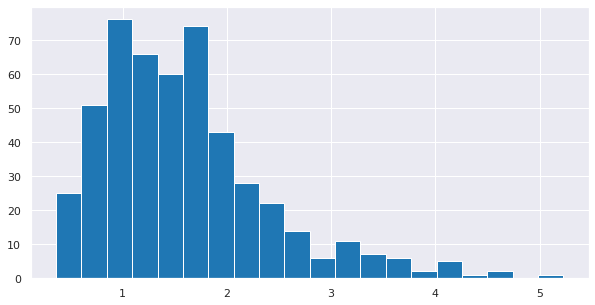

In [152]:
with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 5))

    error = [grad[2] / grad[1] for grad in grad_history]
    # error = [g[2] for g in grad_history]
    plt.hist(error, bins=20)

    plt.show()